In [1]:
DATASET_DIR = "/kaggle/input/dicommammography"
!rm -rf ./* # clear working dir
VINDR_SELECTED_SUBSET_CSV = DATASET_DIR+'/vindr-mammo_selected_images.csv'
VINDR_BIRADS_1_2_CSV = DATASET_DIR+'/vindr-mammo_birads-1_2.csv'
VINDR_ALL_CSV = 'https://drive.usercontent.google.com/u/1/uc?id=12dZ1KqdOs79jB17uFAfvrb-J4EatpQPr&export=download'
VINDR_MULTI_VIEW_CSV = DATASET_DIR+'/vindr_cc_mlo_data.csv'
CBIS_DDSM_ALL_CSV = DATASET_DIR+'/cbis_ddsm_all.csv'
CBIS_DDSM_MULTI_VIEW_CSV = DATASET_DIR+'/cbis_ddsm_dual_view_all.csv'


VINDR_ZIP_FINDINGS_ONLY = DATASET_DIR+'/vindr-mammo_findings_only'
VINDR_ZIP_SELECTED_SUBSET = DATASET_DIR+'/VinDr-Mammo_Balanced_Subset'
VINDR_ZIP_BIRADS_1_2 = DATASET_DIR+'/VinDr-Mammo_BIRADS_1&2_Subset'
CBIS_ZIP_CALC_TRAIN = DATASET_DIR+'/CBIS-DDSM_Calc_Training'
CBIS_ZIP_CALC_TEST = DATASET_DIR+'/CBIS-DDSM_Calc_Test'
CBIS_ZIP_MASS_TRAIN = DATASET_DIR+'/CBIS-DDSM_Mass_Training'
CBIS_ZIP_MASS_TEST = DATASET_DIR+'/CBIS-DDSM_Mass_Test'

cbis_zip_list = [CBIS_ZIP_MASS_TRAIN, CBIS_ZIP_CALC_TRAIN, CBIS_ZIP_MASS_TEST, CBIS_ZIP_CALC_TEST]
label_index = {"BI-RADS 0": 0.0,"BI-RADS 1":1.0,"BI-RADS 2":2.0,"BI-RADS 3":3.0,"BI-RADS 4":4.0,"BI-RADS 5":5.0,}
index_label = {val:key for key,val in label_index.items()}

import os
import random
import pandas as pd
import numpy as np
# import tensorflow as tf

def seed_everything(seed):
    print("seed everything using", seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
#     tf.random.set_seed(seed)

seed_everything(int(1e4*np.e))

columns = ['pair_id', 'image_path_CC', 'zip_file_CC', 'BI_RADS_CC',
                      'image_path_MLO',  'zip_file_MLO', 'BI_RADS_MLO',
           'CC_MLO_Same_BIRADS']
vindr_multi_view = pd.read_csv(VINDR_MULTI_VIEW_CSV)
vindr_multi_view['pair_id'] = vindr_multi_view.apply(lambda row: f"{row['study_id']}_{row['laterality']}" , axis=1)
vindr_multi_view = vindr_multi_view.loc[:,columns]
cbis_multi_view = pd.read_csv(CBIS_DDSM_MULTI_VIEW_CSV)\
                  .rename(columns={
                      'subset_zip_CC':'zip_file_CC',
                      'subset_zip_MLO':'zip_file_MLO',
                      'assessment_CC':'BI_RADS_CC',
                      'assessment_MLO':'BI_RADS_MLO'
                      })
cbis_multi_view = cbis_multi_view.loc[:,columns]

# all_multi_view_df = cbis_multi_view
all_multi_view_df = pd.concat([vindr_multi_view, cbis_multi_view]).reset_index(drop=True)

def normalize_birads(row):
    if row['BI_RADS_CC'] in label_index and row['BI_RADS_MLO'] in label_index:
        row['BI_RADS_CC'] = label_index[row['BI_RADS_CC']]
        row['BI_RADS_MLO'] = label_index[row['BI_RADS_MLO']]
        return row
    else:
        row['BI_RADS_CC'] = float(row['BI_RADS_CC'])
        row['BI_RADS_MLO'] = float(row['BI_RADS_MLO'])
        return row
    
def kaggle_zipfile_path(row):
    for view in ['CC', 'MLO']:
        orig_zip_file = row[f'zip_file_{view}']
        if not isinstance(orig_zip_file, str):
            continue
        kaggle_filename = orig_zip_file.split('/')[-1].replace('.zip','_zip').replace('&','')
        kaggle_zip_file = f"{DATASET_DIR}/{kaggle_filename}"
        row[f'zip_file_{view}'] = kaggle_zip_file
    return row

all_multi_view_df = all_multi_view_df.apply(normalize_birads, axis=1)
all_multi_view_df = all_multi_view_df.apply(kaggle_zipfile_path, axis=1)
all_multi_view_df = all_multi_view_df.dropna().reset_index(drop=True)
all_multi_view_df['BI_RADS_MAX'] = all_multi_view_df.apply(lambda row: max(row['BI_RADS_CC'], row['BI_RADS_MLO']), axis=1)
all_multi_view_df["Benign"] = all_multi_view_df.apply(lambda row: 1 if row['BI_RADS_MAX'] in [1, 2] else 0, axis=1)
all_multi_view_df["Normal"] = all_multi_view_df.apply(lambda row: 1 if row['BI_RADS_MAX'] == 1 else 0, axis=1)
all_multi_view_df

seed everything using 27182


,pair_id,image_path_CC,zip_file_CC,BI_RADS_CC,image_path_MLO,zip_file_MLO,BI_RADS_MLO,CC_MLO_Same_BIRADS,BI_RADS_MAX,Benign,Normal
0,0025a5dc99fd5c742026f0b2b030d3e9_L,vindr-mammo/451562831387e2822923204cf8f0873e.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,1.0,vindr-mammo/2ddfad7286c2b016931ceccd1e2c7bbc.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,1.0,True,1.0,1,1
1,0025a5dc99fd5c742026f0b2b030d3e9_R,vindr-mammo/fcf12c2803ba8dc564bf1287c0c97d9a.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,1.0,vindr-mammo/47c8858666bcce92bcbd57974b5ce522.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,1.0,True,1.0,1,1
2,0028fb2c7f0b3a5cb9a80cb0e1cdbb91_L,vindr-mammo/3704f91985dcbc69f6ac2803523d1ecb.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,2.0,vindr-mammo/7fc1f1bb8bb1a7efaf7104e49c4d8b86.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,2.0,True,2.0,1,0
3,0028fb2c7f0b3a5cb9a80cb0e1cdbb91_R,vindr-mammo/c4ce68631bf70949570ded31a3c69e60.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,2.0,vindr-mammo/16e58fc1d65fa7587247e6224ee96527.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,2.0,True,2.0,1,0
4,0034765af074f93ed33d5e8399355caf_L,vindr-mammo/68f09c18925a66ef2840d4a62f237b31.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,2.0,vindr-mammo/b664cf1e7c968896144a3a2005cd3eb4.d...,/kaggle/input/dicommammography/VinDr-Mammo_Bal...,2.0,True,2.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
2688,P_02460_RIGHT,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,5.0,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,5.0,True,5.0,0,0
2689,P_02508_LEFT,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,4.0,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,4.0,True,4.0,0,0
2690,P_02518_RIGHT,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,5.0,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,5.0,True,5.0,0,0
2691,P_02559_RIGHT,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,3.0,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,3.0,True,3.0,0,0


In [2]:
try:
    import pydicom
except ModuleNotFoundError:
    !pip install pydicom

## Dataset Splitting

In [3]:
# list index yang gambar mamografinya ada kotak putih gede / otsu roi crop malah ngecrop bagian itu -.-
# drop_indexes = [39, 65, 61, 24, 86, 73, 83, 88, 59, 49, 78, 45, 10, 106, 109, 110, 133, 144, 168, 191, 155, 195, 230, 141, 237, 248, 279, 304, 348, 329, 351, 383, 447, 330, 457, 454, 436, 478, 410, 465, 463, 468, 492, 484, 533, 528, 538, 567, 583, 450, 566, 526, 578, 652, 637, 705, 685, 617, 739, 742, 747, 749, 755, 766, 833, 847, 846, 859, 865, 888, 928, 925, 946, 974, 1001, 985, 1030, 1038, 1105, 1108, 1118, 1139, 1124, 1166, 1148, 1208, 1223, 1247, 1246, 1242, 1315, 1286, 1334, 1339, 1358, 1353, 1376, 1388, 1429, 1418, 1422, 1452, 1454, 1473, 1516, 1503, 1492, 1482, 1533, 1538, 1373, 1551, 1539, 1570, 1506, 1556, 1636, 1600, 1642, 1671, 1667, 1686, 1693, 1697, 1655, 1713, 1725, 1760, 1747, 1731, 1762, 1806, 1790, 1804, 1719, 1691, 1826, 1832, 1857, 1845, 1852, 1853, 1881, 1823, 1908, 1934, 1910, 1965, 1989, 1993, 1976, 1924, 1998, 2028, 2050, 2038, 2081, 2075, 2101, 2090, 2135, 2162, 2150, 1994, 2140, 2240, 2243, 2266, 2298, 2262, 2318, 2309, 2260, 2319, 2325, 2370, 2362, 2426, 2460, 2475, 2457, 2445, 2545, 2585, 2622, 2614, 2607, 2617, 2657, 2646, 2669, 2656]
ds = all_multi_view_df.sample(frac=1).reset_index(drop=True)
birads_counts = ds.BI_RADS_MAX.value_counts()
print(len(ds))
print('\n'.join([f"{label} : {birads_counts.get(i)}" for label, i in label_index.items()]))

2693
BI-RADS 0 : None
BI-RADS 1 : 464
BI-RADS 2 : 416
BI-RADS 3 : 500
BI-RADS 4 : 974
BI-RADS 5 : 339


In [4]:
def get_kfold_df(k, kfold_ds=ds.copy(), balanced=True):
    kfold_ds[f"k{k}_split"] = "fold-sisa"
    def train_val_split(_df, k):
        split = 1 / k
        split = round(len(_df)*split) # splitting to k-fold / (100/k)% data each fold
        start_index = 0
        indxs = list(_df.index)
        for i in range(k):
            indx = indxs[start_index:(i+1)*split]
            _df.loc[indx, f"k{k}_split"] = f'fold-{i}'
            start_index+=split
        return _df
    if balanced:
        get_n_sample = lambda _ : birads_counts.min()
        lowest_count_birads = birads_counts.argmin() + 1.0
        low_birads = kfold_ds.loc[ds.BI_RADS_MAX == lowest_count_birads]
        kfold_ds.loc[kfold_ds.BI_RADS_MAX == lowest_count_birads] = train_val_split(low_birads, k)
    else:
        lowest_count_birads = -1
        get_n_sample = lambda df: len(df)
    
    for key in index_label:
        if key == lowest_count_birads or key == 0.0:
            continue
        biradn = kfold_ds.loc[kfold_ds.BI_RADS_MAX == key]
        biradn = biradn.sample(get_n_sample(biradn))
        biradn = train_val_split(biradn, k)
        kfold_ds.iloc[biradn.index,:] = biradn
    return kfold_ds

def print_kfold_birads_counts(k, balanced=True):
    kfold_ds = get_kfold_df(k, balanced=balanced)
    print(kfold_ds[f"k{k}_split"].value_counts())
    for i in range(k):
        fold_birads_counts = kfold_ds[kfold_ds[f"k{k}_split"] == f"fold-{i}"].BI_RADS_MAX.value_counts()
        print(f"fold-{i} birads".center(30, "-"))
        print('\n'.join([f"{label} : {fold_birads_counts.get(i)}" for label, i in label_index.items()]))
    fold_birads_counts = kfold_ds[kfold_ds[f"k{k}_split"] == "fold-sisa"].BI_RADS_MAX.value_counts()
    print(f"fold-sisa birads".center(30, "-"))
    print('\n'.join([f"{label} : {fold_birads_counts.get(i)}" for label, i in label_index.items()]))

In [5]:
print_kfold_birads_counts(k=3)

k3_split
fold-sisa    998
fold-0       565
fold-1       565
fold-2       565
Name: count, dtype: int64
--------fold-0 birads---------
BI-RADS 0 : None
BI-RADS 1 : 113
BI-RADS 2 : 113
BI-RADS 3 : 113
BI-RADS 4 : 113
BI-RADS 5 : 113
--------fold-1 birads---------
BI-RADS 0 : None
BI-RADS 1 : 113
BI-RADS 2 : 113
BI-RADS 3 : 113
BI-RADS 4 : 113
BI-RADS 5 : 113
--------fold-2 birads---------
BI-RADS 0 : None
BI-RADS 1 : 113
BI-RADS 2 : 113
BI-RADS 3 : 113
BI-RADS 4 : 113
BI-RADS 5 : 113
-------fold-sisa birads-------
BI-RADS 0 : None
BI-RADS 1 : 125
BI-RADS 2 : 77
BI-RADS 3 : 161
BI-RADS 4 : 635
BI-RADS 5 : None


In [6]:
#  balanced-fold unbalance dataset
print_kfold_birads_counts(k=3, balanced=False)

k3_split
fold-1    899
fold-0    899
fold-2    895
Name: count, dtype: int64
--------fold-0 birads---------
BI-RADS 0 : None
BI-RADS 1 : 155
BI-RADS 2 : 139
BI-RADS 3 : 167
BI-RADS 4 : 325
BI-RADS 5 : 113
--------fold-1 birads---------
BI-RADS 0 : None
BI-RADS 1 : 155
BI-RADS 2 : 139
BI-RADS 3 : 167
BI-RADS 4 : 325
BI-RADS 5 : 113
--------fold-2 birads---------
BI-RADS 0 : None
BI-RADS 1 : 154
BI-RADS 2 : 138
BI-RADS 3 : 166
BI-RADS 4 : 324
BI-RADS 5 : 113
-------fold-sisa birads-------
BI-RADS 0 : None
BI-RADS 1 : None
BI-RADS 2 : None
BI-RADS 3 : None
BI-RADS 4 : None
BI-RADS 5 : None


In [7]:
k_range = 3, 6
for balancing in ["balanced", "unbalanced"]:
    balanced = True if balancing=="balanced" else False
    kfold_ds = ds.copy()
    collumns_to_save = ["pair_id","BI_RADS_MAX","Benign","Normal"]
    for k in range(*k_range):
        kfold_ds = get_kfold_df(k, kfold_ds, balanced)
        collumns_to_save.append(f"k{k}_split")
    kfold_ds = kfold_ds.loc[:, collumns_to_save].rename(columns={"BI_RADS_MAX":"label"})
    print(len(kfold_ds))
    kfold_ds.to_csv(f"{balancing}_k-fold_splits.csv",index=False)
kfold_ds.head()

2693
2693


,pair_id,label,Benign,Normal,k3_split,k4_split,k5_split
0,55dfb11244b9a73d5ec8131783f5b7f7_R,5.0,0,0,fold-2,fold-0,fold-4
1,P_00351_LEFT,3.0,0,0,fold-1,fold-0,fold-0
2,P_00774_RIGHT,4.0,0,0,fold-1,fold-2,fold-4
3,P_00862_LEFT,4.0,0,0,fold-2,fold-2,fold-2
4,P_00498_LEFT,4.0,0,0,fold-0,fold-1,fold-0


## processing DICOM

In [8]:
import cv2
import pydicom
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from pydicom.pixel_data_handlers.util import apply_voi_lut
from io import BytesIO


def get_laterality(data: np.ndarray):
    # setelah eksperimen lebih lanjut , lebih baik resize sebelum deteksi laterality
    data = cv2.resize(data.copy(), (144, 256), interpolation=cv2.INTER_LINEAR)
    mean_L = np.mean(data[:, :40])
    mean_R = np.mean(data[:, -40:])
    if mean_L == mean_R:
        laterality = "<?>"
    elif (mean_L < 200) and (mean_R < 200):
        laterality = 'L' if mean_L > mean_R else 'R'
    else:
        laterality = 'L' if mean_L < mean_R else 'R'
    return laterality


def cut_far_pixels(img, laterality):
    _, width = img.shape[:2]
    cut = None
    for c in np.arange(0.5, 0.1, -0.01):
        far_cuts = int(c*width)
        if laterality == "L":
            far = img[:, -far_cuts:]
        elif laterality == "R":
            far = img[:, :far_cuts]
        else:
            break
        percentile0 = np.percentile(far, 70)
        percentile1 = np.percentile(far, 95)
        is_save_to_cut = percentile0 > 200 or percentile1 < 10
        if is_save_to_cut:
            cut = width-far_cuts
            break
    if laterality == "L":
        return img[:, :cut]
    elif laterality == "R":
        return img[:, -(cut or 0):]
    else:
        return img
    
def extract_roi_otsu(data, gkernel=(5, 5), area_pct_tresh=0.004):
    '''copied with edit from 
    https://github.com/dangnh0611/kaggle_rsna_breast_cancer/blob/bf30f8753c564874e1e7862bafd99b09a0471165/src/roi_det/roi_extract.py#L25'''
    ori_h, ori_w = data.shape[:2]
    img = data.copy()
    # clip percentile: implant, white lines
    upper = np.percentile(img, 95)
    img[img > upper] = np.min(img)
    # Gaussian filtering to reduce noise (optional)
    if gkernel is not None:
        img = cv2.GaussianBlur(img, gkernel, 0.1)
        img = cv2.normalize(img, None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U) 
    _, img_bin = cv2.threshold(img, 0, 255,
                               cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # dilation to improve contours connectivity
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3), (-1, -1))
    img_bin = cv2.dilate(img_bin, element)
    cnts, _ = cv2.findContours(img_bin.astype(np.uint8), cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return [0, 0, ori_w, ori_h], False
    areas = np.array([cv2.contourArea(cnt) for cnt in cnts])
    select_idx = np.argmax(areas)
    cnt = cnts[select_idx]
    area_pct = areas[select_idx] / (img.shape[0] * img.shape[1])
    if area_pct < area_pct_tresh:
        return [0, 0, ori_w, ori_h], False
    x0, y0, w, h = cv2.boundingRect(cnt)
    # min-max for safety only
    # x0, y0, x1, y1
    x1 = min(max(int(x0 + w), 0), ori_w)
    y1 = min(max(int(y0 + h), 0), ori_h)
    x0 = min(max(int(x0), 0), ori_w)
    y0 = min(max(int(y0), 0), ori_h)
    return [x0, y0, x1, y1], True

def roi_cropping_image(data, area_pct_tresh=0.02):
    (x0, y0, x1, y1), success = extract_roi_otsu(data, (5,5), area_pct_tresh)
    if success:
        data = data[y0:y1,x0:x1]
    return data, success

def pad_to_scale_ratio(img, laterality, scale, pad_value=0):
    height, width = img.shape[:2]
    target_ratio = scale[0] / scale[1]

    if width / height > target_ratio:  # Image is wider than 9:16
        new_width = width
        new_height = int(width / target_ratio)
        top_bottom_padding = (new_height - height) // 2
        left_right_padding = 0
    else:  # Image is taller than 9:16
        new_width = int(height * target_ratio)
        new_height = height
        top_bottom_padding = 0
        if laterality == "R":
            left_right_padding = (new_width - width)
        else:
            left_right_padding = 0

    # Create a blank image with the target dimensions
    padded_img = np.ones((new_height, new_width), dtype=np.uint8) * pad_value

    # Copy the original image onto the padded image with the calculated offsets
    padded_img[top_bottom_padding:top_bottom_padding + height,
               left_right_padding:left_right_padding + width] = img

    return padded_img


def read_dicom(path,
               voi_lut: bool = True,
               fix_monochrome: bool = True):
    dicom = pydicom.read_file(path)
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

def preprocess_images_multi_view(
                      img_cc: np.ndarray, img_mlo: np.ndarray,
                      pad_scale: tuple = (1, 1),
                      pad_value: int = 0,
                      roi_crop: str = None,
                      resize: tuple|list = (288, 512),
                      return_misch: bool=False,
                     ):
    
    cc_lat_before = get_laterality(img_cc)
    mlo_lat_before = get_laterality(img_mlo)
    # otsu roi cropping
    if roi_crop == 'otsu':
        img_cc_crop = cut_far_pixels(img_cc, cc_lat_before)
        img_mlo_crop = cut_far_pixels(img_mlo, mlo_lat_before)
        img_cc_crop, cc_success = roi_cropping_image(img_cc_crop)
        img_mlo_crop, mlo_success = roi_cropping_image(img_mlo_crop)
        if cc_success and mlo_success:
            img_cc = img_cc_crop
            img_mlo = img_mlo_crop
    elif roi_crop is not None:
        img_cc = cut_far_pixels(img_cc, cc_lat_before)
        img_mlo = cut_far_pixels(img_mlo, mlo_lat_before)
    # padding
    if pad_scale is not None:
        img_cc = pad_to_scale_ratio(img_cc, get_laterality(img_cc), pad_scale, pad_value)
        img_mlo = pad_to_scale_ratio(img_mlo, get_laterality(img_mlo), pad_scale, pad_value)
    # resize
    if resize is not None:
        img_cc = cv2.resize(img_cc, resize, interpolation=cv2.INTER_LINEAR)
        img_mlo = cv2.resize(img_mlo, resize, interpolation=cv2.INTER_LINEAR)
    pct75_cc = np.percentile(img_cc, 75)
    pct75_mlo = np.percentile(img_mlo, 75)
    cc_lat_after = get_laterality(img_cc)
    mlo_lat_after = get_laterality(img_mlo)
    if return_misch:
        return (img_cc, img_mlo), (pct75_cc, pct75_mlo), (cc_lat_before, mlo_lat_before), (cc_lat_after, mlo_lat_after)
    else:
        return img_cc, img_mlo

def read_preprocess_dicoms(path_cc, path_mlo, return_misc=True):
    data_cc = read_dicom(path_cc,voi_lut=True,fix_monochrome=True)
    data_mlo = read_dicom(path_mlo,voi_lut=True,fix_monochrome=True)
    return preprocess_images_multi_view(
                      data_cc, data_mlo,
                      pad_scale = (9, 16),
                      pad_value = 0,
                      roi_crop = 'otsu',
                      resize = (288, 512),
                      return_misch=return_misc,
                     )
    
def load_dicom_from_zip(cc_paths, mlo_paths, return_misc=False):
    def read_image_bytes(image_path, zipfile_path):
        with zipfile.ZipFile(zipfile_path, "r") as zip_ref:
            with zip_ref.open(image_path) as f:
                return BytesIO(f.read())
    cc_bytes = read_image_bytes(*cc_paths)
    mlo_bytes = read_image_bytes(*mlo_paths)
    result = read_preprocess_dicoms(cc_bytes, mlo_bytes, return_misc=return_misc)
    del cc_bytes
    del mlo_bytes
    return result

In [9]:
import os
import multiprocessing as mp
from tqdm import tqdm


def inspection(row):
    index, row = row
    infos = {"index":index, "pair_id":row['pair_id']}
    paths_cc = (row["image_path_CC"], row["zip_file_CC"])
    paths_mlo = (row["image_path_MLO"], row["zip_file_MLO"])
    (img_cc, img_mlo), *misch = load_dicom_from_zip(paths_cc, paths_mlo, return_misc=True)
    (pct75_cc, pct75_mlo), lat_befores, lat_afters = misch
    infos["pct75_cc"] = pct75_cc
    infos["pct75_mlo"] = pct75_mlo
    lat_befores = np.unique(lat_befores)
    lat_afters = np.unique(lat_afters)
    infos["lat_before_unique"] = len(lat_befores) == 1
    infos["lat_after_unique"] = len(lat_befores) == 1
    infos["lat_before_eq_lat_after"] = (lat_befores == lat_afters).all()
    return infos
    

def run_inspection(df):
    # start process
    with mp.Pool(mp.cpu_count()) as p:
        iterrows = list(df.iterrows())
        generator = tqdm(
            p.imap_unordered(inspection, iterrows),
            total=len(iterrows),
            desc="running"
        )
        return list(generator)

r = run_task_multiprocess(all_multi_view_df.copy())
r_df = pd.DataFrame(r).sort_values(by="index").set_index('index')
r_df.to_csv("inspection_report.csv",index=False)
r_df.head()

running: 100%|██████████| 2693/2693 [01:47<00:00, 24.96it/s]


,pair_id,pct75_cc,pct75_mlo,lat_before_unique,lat_after_unique,lat_before_eq_lat_after
index,,,,,,
0,0025a5dc99fd5c742026f0b2b030d3e9_L,96.0,112.0,True,True,True
1,0025a5dc99fd5c742026f0b2b030d3e9_R,96.0,109.0,True,True,True
2,0028fb2c7f0b3a5cb9a80cb0e1cdbb91_L,95.0,109.0,True,True,True
3,0028fb2c7f0b3a5cb9a80cb0e1cdbb91_R,93.0,102.0,True,True,True
4,0034765af074f93ed33d5e8399355caf_L,94.0,76.0,True,True,True


In [10]:
rdf_filter = r_df.lat_before_eq_lat_after == False
r_df[rdf_filter]

,pair_id,pct75_cc,pct75_mlo,lat_before_unique,lat_after_unique,lat_before_eq_lat_after
index,,,,,,
1548,P_00037_RIGHT,102.0,71.0,True,True,False
1724,P_00346_RIGHT,116.0,106.0,True,True,False
1882,P_00578_LEFT,117.0,165.0,True,True,False
1948,P_00693_LEFT,104.0,126.0,True,True,False
1981,P_00744_RIGHT,115.0,147.0,True,True,False
2127,P_00987_LEFT,163.0,101.0,True,True,False
2181,P_01073_RIGHT,68.0,130.0,True,True,False
2340,P_01338_LEFT,69.0,126.0,True,True,False
2373,P_01397_LEFT,138.0,155.0,True,True,False


In [11]:
drop_indexes = r_df[rdf_filter].index
all_multi_view_df.loc[drop_indexes,:]

,pair_id,image_path_CC,zip_file_CC,BI_RADS_CC,image_path_MLO,zip_file_MLO,BI_RADS_MLO,CC_MLO_Same_BIRADS,BI_RADS_MAX,Benign,Normal
index,,,,,,,,,,,
1548,P_00037_RIGHT,Mass-Test_full_mammogram_images-doiJNLP-6ccCrb...,/kaggle/input/dicommammography/CBIS-DDSM_Mass_...,5.0,Mass-Test_full_mammogram_images-doiJNLP-6ccCrb...,/kaggle/input/dicommammography/CBIS-DDSM_Mass_...,5.0,True,5.0,0,0
1724,P_00346_RIGHT,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,4.0,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,3.0,False,4.0,0,0
1882,P_00578_LEFT,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,4.0,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,4.0,True,4.0,0,0
1948,P_00693_LEFT,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,5.0,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,5.0,True,5.0,0,0
1981,P_00744_RIGHT,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,2.0,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,2.0,True,2.0,1,0
2127,P_00987_LEFT,Mass-Test_full_mammogram_images-doiJNLP-6ccCrb...,/kaggle/input/dicommammography/CBIS-DDSM_Mass_...,5.0,Mass-Test_full_mammogram_images-doiJNLP-6ccCrb...,/kaggle/input/dicommammography/CBIS-DDSM_Mass_...,5.0,True,5.0,0,0
2181,P_01073_RIGHT,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,3.0,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,3.0,True,3.0,0,0
2340,P_01338_LEFT,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,4.0,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,4.0,True,4.0,0,0
2373,P_01397_LEFT,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,5.0,Calc-Training_full_mammogram_images_1-doiJNLP-...,/kaggle/input/dicommammography/CBIS-DDSM_Calc_...,5.0,True,5.0,0,0


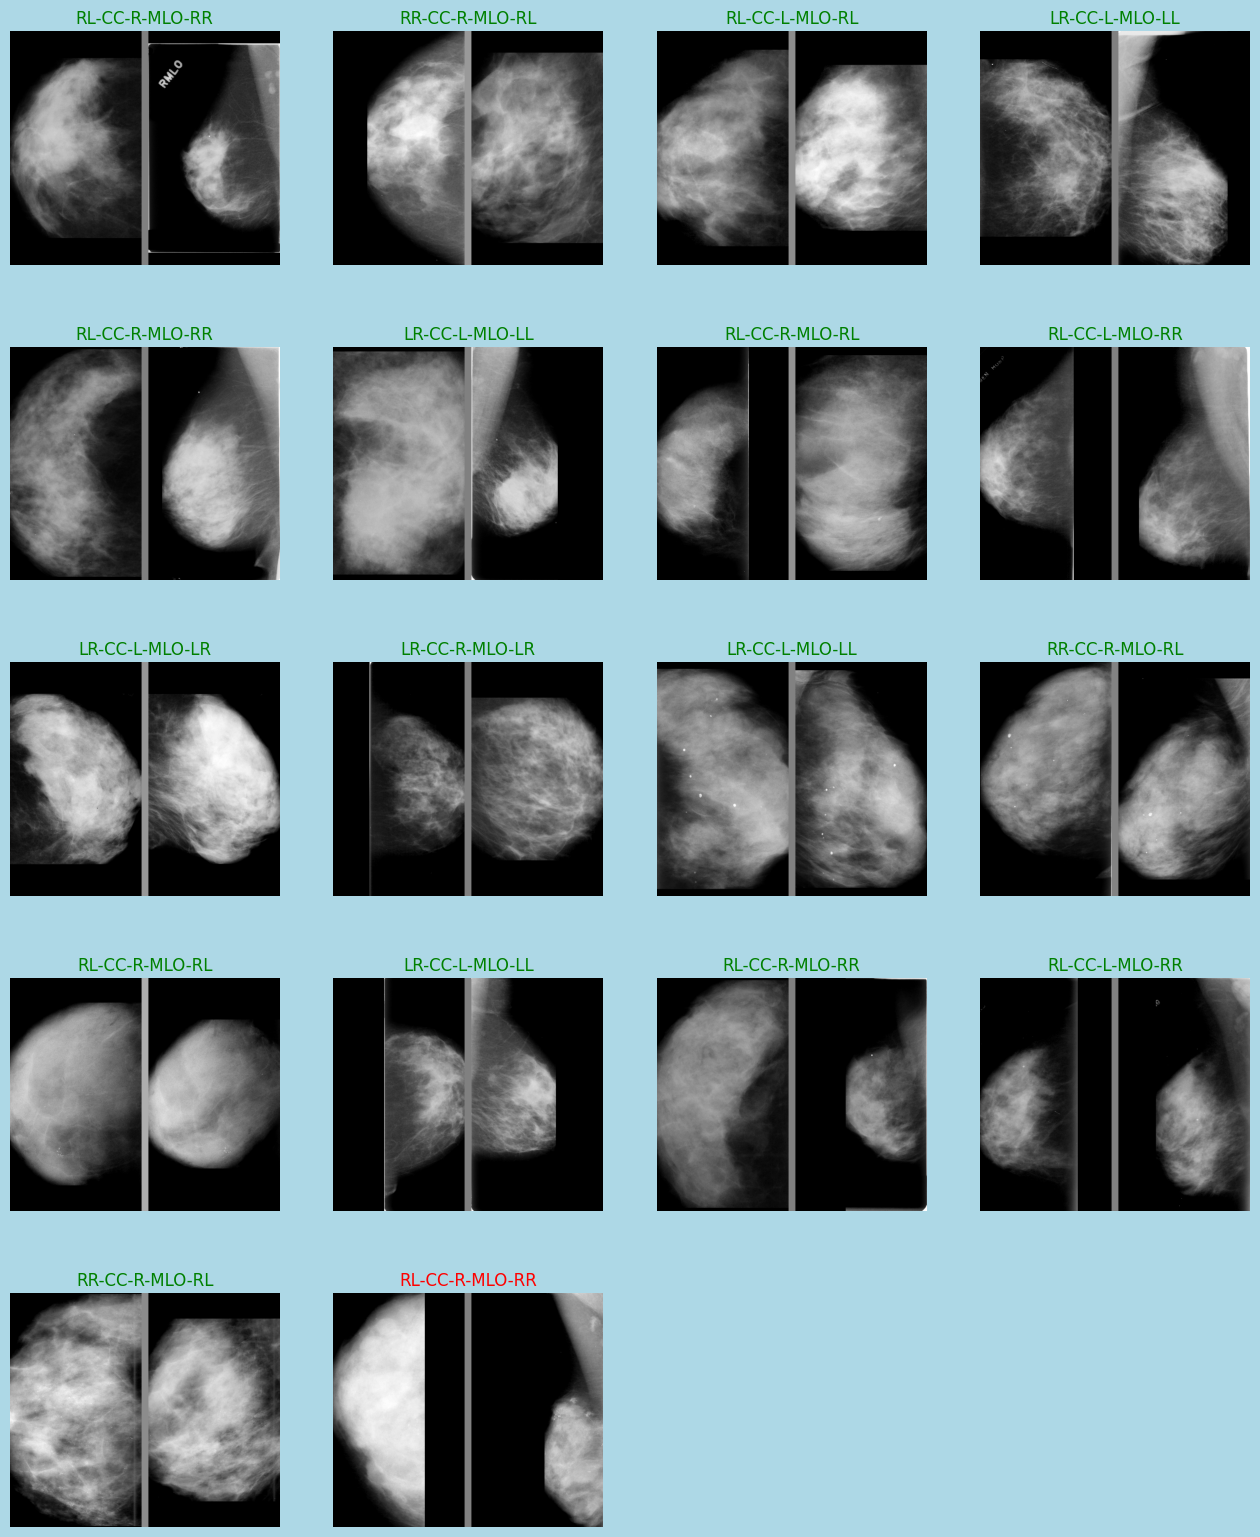

In [12]:
ncol = 4
nrow = 7
bar_color = [128]
viz_ds = all_multi_view_df.copy().loc[drop_indexes,:].reset_index(drop=True)
# viz_ds = all_multi_view_df.copy().sample(frac=1).reset_index(drop=True)

bar_thickness = 15
bar = np.array([bar_color * bar_thickness]*512)
random_index = np.random.randint(0,(len(viz_ds)-ncol*nrow)) if len(viz_ds) > (ncol*nrow) else 0

plt.figure(figsize=(4*ncol, 4*nrow), facecolor='lightblue')
for i in range(nrow*ncol):
    try:
        _id0, *paths_cc = viz_ds.loc[random_index+i, ["pair_id","image_path_CC","zip_file_CC"]]
        _id1, *paths_mlo = viz_ds.loc[random_index+i, ["pair_id","image_path_MLO","zip_file_MLO"]]
    except KeyError:
        break
    laterality=_id0.split("_")[-1][0]
    (img_cc, img_mlo), *misch = load_dicom_from_zip(tuple(paths_cc), tuple(paths_mlo), return_misc=True)
    (pct75_cc, pct75_mlo), (latcc0, latmlo0), (latcc1, latmlo1) = misch
    img = np.hstack((img_cc,bar,img_mlo))
    if (10 <= pct75_cc <= 200) and (10 <= pct75_mlo <= 200):
        color = "green"
    else:
        color = "red"
    plt.subplot(nrow, ncol, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{latcc0+latcc1}-CC-{laterality}-MLO-{latmlo0+latmlo1}", color=color)
    plt.axis("off")
plt.show()

# Convert DICOM to PNG images

In [18]:
import os
import multiprocessing as mp
from tqdm.auto import tqdm

base_dir = ""
cardinality = 9999999999

def load_and_save(row):
    global base_dir
    index, row = row
    infos = {"index":index, "pair_id":row['pair_id']}
    filename_cc = os.path.join(base_dir, f"{row['pair_id']}-CC.png")
    filename_mlo = os.path.join(base_dir, f"{row['pair_id']}-MLO.png")
    if os.path.exists(filename_cc) and os.path.exists(filename_mlo):
        return
    paths_cc = (row["image_path_CC"], row["zip_file_CC"])
    paths_mlo = (row["image_path_MLO"], row["zip_file_MLO"])
    img_cc, img_mlo = load_dicom_from_zip(paths_cc, paths_mlo, return_misc=False)
    cv2.imwrite(filename_cc, img_cc)
    cv2.imwrite(filename_mlo, img_mlo)
    return
    

def convert_dicoms_to_pngs(folder_name, kfold_ds):
    global base_dir
    base_dir = f'/kaggle/working/{folder_name}'
    print("saving PNG images to", base_dir)
    os.makedirs(base_dir, exist_ok=True)
    # start process
    with mp.Pool(mp.cpu_count()) as p:
        iterrows = list(kfold_ds.iterrows())[:cardinality]
        image_generator = tqdm(
            p.imap_unordered(load_and_save, iterrows),
            total=len(iterrows),
            desc="converting images"
        )
        list(image_generator)

print("creating images dataset".center(50, "."))
convert_dicoms_to_pngs("images", ds)

.............creating images dataset..............
saving PNG images to /kaggle/working/images


converting images: 100%|██████████| 2693/2693 [00:00<00:00, 18344.86it/s]


In [14]:
import os
import zipfile

base_dir = 'example_dicom'
!rm -rf {base_dir}
os.makedirs(base_dir, exist_ok=True)

def save_dicom(image_path, zipfile_path, save_filename):
    with zipfile.ZipFile(zipfile_path, "r") as zip_ref:
        with zip_ref.open(image_path) as f:
            image_bytes = f.read()
    with open(save_filename, "wb") as f:
        f.write(image_bytes)
    
n_data_to_save = 1
df_list = []
for key in index_label:
    print(key)
    if key == 0.0:
        continue
    biradn = ds.loc[ds.BI_RADS_MAX == key].sample(n_data_to_save)
    df_list.append(biradn)

sample_df = pd.concat(df_list, ignore_index=True)
for _, row in sample_df.iterrows():
    label = int(row['BI_RADS_MAX'])
    for view in ["CC", "MLO"]:
        save_filename = os.path.join(base_dir, f"birads_{label}_example_{view}.dicom")
        if os.path.exists(save_filename):
            continue
        zipfile_path = row[f'zip_file_{view}']
        image_path = row[f'image_path_{view}']
        save_dicom(image_path, zipfile_path, save_filename)
        
!tar -zcvf example_dicom_tar_gz {base_dir} && rm -rf {base_dir}

0.0
1.0
2.0
3.0
4.0
5.0
example_dicom/
example_dicom/birads_2_example_MLO.dicom
example_dicom/birads_1_example_MLO.dicom
example_dicom/birads_4_example_MLO.dicom
example_dicom/birads_5_example_CC.dicom
example_dicom/birads_1_example_CC.dicom
example_dicom/birads_5_example_MLO.dicom
example_dicom/birads_3_example_MLO.dicom
example_dicom/birads_3_example_CC.dicom
example_dicom/birads_2_example_CC.dicom
example_dicom/birads_4_example_CC.dicom


In [15]:
# import cv2
# import numpy as np
# import tensorflow as tf

# print(tf.__version__)

# im = cv2.imread("/kaggle/working/images/a235482f737d9a3baa8313c8f4db16d6_L-MLO.png")
# im = cv2.resize(im, (1024, 1024))
# # im = cv2.flip(im, 1)

# # interpreter = tf.lite.Interpreter("/kaggle/input/mammo-roi-detector/tflite/yolov5/1/best-fp16.tflite")
# # interpreter.allocate_tensors()
# # inputs = interpreter.get_input_details()[0]
# # output = interpreter.get_output_details()[0]
# # interpreter.set_tensor(inputs["index"], np.expand_dims(im, 0).astype("float32"))
# # interpreter.invoke()
# # o = interpreter.get_tensor(output["index"])
# # index, total_boxes = tf.image.non_max_suppression_padded(
# #     o[...,:4],
# #     o[...,4],
# #     1,
# #     iou_threshold=0.5,
# #     score_threshold=0.5,
# #     pad_to_max_output_size=True,
# # )
# # print(o[0, index[0]])

# import cv2

# def get_bbox_absolute_pixel(bbox, image_shape):
#     if not len(image_shape) == 3:
#         raise NotImplementedError("this function expect image shape with len == 3")
#     h, w, _ = image_shape
#     bbox = np.array(bbox)
#     if not len(bbox.shape) == 1:
#         raise NotImplementedError("this function expect bbox shape with len == 1")
#     bbox[[0,2]]*=w
#     bbox[[1,3]]*=h
#     bbox = bbox.astype(int)
#     return bbox

# def xywh2xyxy(bbox):
#     x0, y0, w, h = bbox
#     x1 = x0 + w
#     y1 = y0 + h
#     return x0, y0, x1, y1

# # bbox = get_bbox_absolute_pixel(o[0, index[0], :4][0], im.shape)
# # bbox = xywh2xyxy(bbox)
# bbox = np.array(crop_coords(np.mean(im, axis=-1)))
# bbox = xywh2xyxy(bbox)
# print(bbox)
# x_min, y_min, x_max, y_max = bbox
# img = cv2.rectangle(im.astype("uint8"), (x_min, y_min), (x_max, y_max), (255, 0, 0), 5)
# # img = im[y_min:y_max,x_min:x_max]

# sum_L = np.sum(img[:, :20])
# sum_R = np.sum(img[:, -20:])
# laterality = 'L' if sum_L > sum_R else 'R'
# print(laterality)
# plt.imshow(img)

In [16]:
# def get_label(file_path):
#     path_parts = tf.strings.split(file_path, os.path.sep)
#     filename_parts = tf.strings.split(path_parts[-1], "_")
#     label = tf.strings.to_number(filename_parts[-3],out_type=tf.dtypes.int32)

#     return tf.one_hot(label-1,5)

# def decode_img(img):
#     img = tf.io.decode_png(img, channels=3)
#     # Resize the image to the desired size
#     return tf.image.resize(img, (512,288))

# def process_image(file_path):
#     # Load the raw data from the file as a string
#     img = tf.io.read_file(file_path)
#     img = decode_img(img)
#     return img

# splits = ['train', 'valid', 'sisa']
# view_map = {"Examined":"CC", "Aux":"MLO"}
# dict_dataset = { split:[{v:None for v in view_map},[]] for split in splits}
# images_dir = '/kaggle/working/images'

# #https://www.tensorflow.org/tutorials/load_data/images?hl=en#using_tfdata_for_finer_control
# for split in splits:
#     for view in view_map:
#         dict_dataset[split][0][view] = tf.data.Dataset.list_files(f"{images_dir}/*_{view_map[view]}_{split}.png",shuffle=False)
# for split in splits:
#     for view in view_map:
#         ds = dict_dataset[split][0][view]
#         print(f'{view}-{split} cardinality :',ds.cardinality().numpy())
#         print('examples :')
#         for f in ds.take(2):
#             print(f.numpy())
#         print()
        
# for split in splits:
#     dict_dataset[split][1] = dict_dataset[split][0][view].map(get_label, num_parallel_calls=tf.data.AUTOTUNE)
#     for view in view_map:
#         dict_dataset[split][0][view] = dict_dataset[split][0][view].map(process_image, num_parallel_calls=tf.data.AUTOTUNE)

# for image in dict_dataset['train'][0]['Examined'].take(5):
#     print("Image shape: ", image.numpy().shape)
# for label in  dict_dataset['train'][1].take(5):
#     print("Label: ", label.numpy())
    
# print("\nunique labels :\n",np.unique(list(dict_dataset['valid'][1].as_numpy_iterator()), axis=0))

# train_ds = tf.data.Dataset.zip(tuple(dict_dataset['train']))
# validation_ds = tf.data.Dataset.zip(tuple(dict_dataset['valid']))
# test_ds = tf.data.Dataset.zip(tuple(dict_dataset['sisa']))


# del dict_dataset
# train_ds

In [17]:
# def _bytes_feature(value):
#     """Returns a bytes_list from a string / byte."""
#     if isinstance(value, type(tf.constant(0))):  # if value is tensor
#         value = value.numpy()  # get value of tensor
#     return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# def serialize_example(image_dict, label):
#     feature = {
#       'Examined': _bytes_feature(image_dict['Examined'].numpy().tobytes()),
#       'Aux': _bytes_feature(image_dict['Aux'].numpy().tobytes()),
#       'label': _bytes_feature(label.numpy().tobytes())  # Assuming one-hot encoded
#     }
#     example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
#     return example_proto.SerializeToString()

# # Function to write TFRecord file
# def write_tfrecord(dataset, output_file):
#     with tf.io.TFRecordWriter(output_file) as writer:
#         for image_dict, label in dataset:
#             example = serialize_example(image_dict, label)
#             writer.write(example)

# # Create separate TFRecord files for training and validation
# write_tfrecord(train_ds, 'train.tfrecord')
# write_tfrecord(validation_ds, 'valid.tfrecord')
# write_tfrecord(test_ds, 'sisa.tfrecord')